In [ ]:
  ### installs
  #def run(jsn = 'missing'):
  !pip install google-cloud-automl
  !pip install google-cloud-storage
  !pip install opencv-python==3.3.0.9
  !pip install keras
  !pip install https://github.com/OlafenwaMoses/ImageAI/releases/download/2.0.2/imageai-2.0.2-py3-none-any.whl
  !pip install tensorflow==1.12.0

In [1]:
  ### imports

  from google.cloud import automl_v1beta1 # Imports the Google Cloud client library
  from google.cloud.automl_v1beta1.proto import service_pb2
  #from google.datalab import storage as strg
  from google.cloud import storage
  from IPython.display import Image
  from PIL import Image as Img
  from imageai.Detection import ObjectDetection
  from google.cloud.storage import Blob
  import datetime
  import google.cloud.bigquery as bq
  import tensorflow as tf
  import matplotlib.pyplot as plt
  import math
  import cv2
  import numpy as np
  import pandas as pd
  import glob
  import json
  import io

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [38]:
  # Instantiates a client
  storage_client = storage.Client()

  # The name for the new bucket
  bucket_name = 'saleshousephotos'

  bucket = storage_client.get_bucket(bucket_name)
  blobs = bucket.list_blobs()

  ######### toto tu nebude ##########
  photos = []
  for blob in blobs:
    if 'photos' in blob.name:
      photos.append(blob.name)
  #photos = photos[-1]
  ###################################

  ########## michal.mlaka ###########
  # photos = URL k dane fotce ktera prijde
  # pripluje photo_ID
  
  #if jsn == 'missing':
  #  bucket_name = 'saleshouse-test-output'
  #  bucket = storage_client.get_bucket(bucket_name)
  #  jsn = Blob("newphoto.json", bucket)
  #  jsn = json.loads(jsn.download_as_string().decode('utf-8'))
 
  #photos = jsn['name']
  #bucket_name = jsn['bucket'] 
  #bucket = storage_client.get_bucket(bucket_name)
  
  jsn = {"bucket": "saleshouse-test-pipeline", "contentType": "image/jpeg", "crc32c": "uH7RjA==", "etag": "CN/0h77T5d4CEAE=", "generation": "1542809022757471", "id": "saleshouse-test-pipeline/photos/15428090045761973780038.jpg/1542809022757471", "kind": "storage#object", "md5Hash": "S+F908zB4FNUDAoqL07QOA==", "mediaLink": "https://www.googleapis.com/download/storage/v1/b/saleshouse-test-pipeline/o/photos%2F15428090045761973780038.jpg?generation=1542809022757471&alt=media", "metageneration": "1", "name": "photos/15428090045761973780038.jpg", "selfLink": "https://www.googleapis.com/storage/v1/b/saleshouse-test-pipeline/o/photos%2F15428090045761973780038.jpg", "size": "2611476", "storageClass": "REGIONAL", "timeCreated": "2018-11-21T14:03:42.757Z", "timeStorageClassUpdated": "2018-11-21T14:03:42.757Z", "updated": "2018-11-21T14:03:42.757Z"}
  #bucket_name = jsn['bucket']
  photos[-4]

'photos/kbx2.jpg'

In [2]:
  ### functions neeeded

  def blur_image(image, amount=5):
      '''Blurs the image
      Does not affect the original image'''
      kernel = np.ones((amount, amount), np.float32) / (amount**2)
      return cv2.filter2D(image, -1, kernel)

  def colour_frame(img, frame, width=5, colour=[0, 0, 0]):
      """"""
      x1, y1, x2, y2 = frame['box_points']
      img[y1:y2, x1-width:x1+width] = colour
      img[y1:y2, x2-width:x2+width] = colour
      img[y1-width:y1+width, x1:x2] = colour
      img[y2-width:y2+width, x1:x2] = colour
      return img


  def colour_map(shelf):
      MAP = {0: [255, 0, 0], 1: [0, 0, 255], 2: [0, 255, 0], 3: [0, 255, 255], 4: [255, 255, 0], 5: [24, 49, 216], 6: [0, 209, 229], 7: [46, 60, 62], 8: [0, 0, 0 ]}
      if shelf < 0:
          return [0, 0, 0 ]
      return MAP.get(shelf % len(MAP))


  def compute_dominance_relations(detections):
      """"""
      for i, frame in enumerate(detections):
          x1, y1, x2, y2 = frame['box_points']
          for j, frame_ in enumerate(detections):
              x1_, y1_, x2_, y2_ = frame_['box_points']
              if y2 < y1_:
                  dominated_by = frame_.setdefault('dominated_by', set())
                  dominated_by.add(i)


  def compute_seed_shelves(detections, polish=1/4):
      """"""
      frame_indeces = {i for i in range(len(detections))}    
      shelf = -1
      shelves = []
      while frame_indeces:
          shelf_frames = set()  
          for i in frame_indeces:
              frame = detections[i]
  #            current_frame = colour_frame(main_obj, frame)
  #            Image.fromarray(current_frame, 'RGB').show()
              dominated_by = (detections[i] for i in frame.get('dominated_by', {}))
              if all(dominating_frame.get('shelf', float('inf')) <= shelf 
                     for dominating_frame in dominated_by):
                  x1, y1, x2, y2 = frame['box_points']
                  upper_shelf_bottoms = [detections[i]['box_points'][3] for i in shelves[-1]] if shelf > -1 else []
                  if sum(y2_ >= y2 - GAP for y2_ in upper_shelf_bottoms) > polish*len(upper_shelf_bottoms):
  #                if all(y2_ >= y2 - GAP for y2_ in upper_shelf_bottoms):

                      frame['shelf'] = shelf
                      shelves[-1].add(i)
                  else:
                      frame['shelf'] = shelf + 1
                      next_shelf = True
                      shelf_frames.add(i)
  #                main_obj = colour_frame(main_obj, frame, colour=colour_map(shelf))
  #                img = Image.fromarray(main_obj, 'RGB')
          frame_indeces -= shelf_frames
          if shelf > -1:
              frame_indeces -= shelves[-1]
          shelves.append(shelf_frames)

          shelf += 1 if next_shelf else 0
      return detections


  def detect_nonshelves(detections, main_obj):
      """"""
      shelves = [set()  for _ in range(20)]
      for iframe, frame in enumerate(detections):
          shelves[frame['shelf']].add(iframe)

      image_width = main_obj.shape[1]
      to_remove = []
      for ishelf, shelf in enumerate(shelves[:-1]):
          lower_tops = [(detections[j]['box_points'][1], detections[j]['box_points'][2]) for j in shelves[ishelf+1]]
          if not lower_tops:
              continue
          noshelf = []
          for i in shelf:
              frame = detections[i]
              frame_bottom = frame['box_points'][3]
              frame_top = frame['box_points'][1]
              if sum(y1 < frame_bottom for y1, y2 in lower_tops) > 0*len(lower_tops)/2:
  #                frame['shelf'] = -1
                  noshelf.append(frame)
  #        Image.fromarray(colour_shelves(noshelf, main_obj.copy()), 'RGB').show()
          safety_condition = noshelf and (min(f['box_points'][0] for f in noshelf) > image_width*1/2
                          or max(f['box_points'][2] for f in noshelf) < image_width*1/2)
          if safety_condition:
              for f in noshelf:
                  f['shelf'] = -1
              to_remove.extend(noshelf)
      for frame in detections:
          if to_remove:
              if frame['box_points'][2] > image_width/2:
                  if frame['box_points'][2] >= min(f['box_points'][0] for f in to_remove) > image_width/2:
                      frame['shelf'] = -1
              elif frame['box_points'][2] < image_width/2:
                  if frame['box_points'][0] <= max(f['box_points'][2] for f in to_remove) < image_width/2:
                      frame['shelf'] = -1
      return detections


  def detect_shelves(detections, polish=1/4):
      """Detekuje regaly na zaklade detekci lahvi. Vadi FALSE POSITIVES.
      V prvni iteraci je ale treba ponechat vysi FALSE POSITVES, abychom meli nizsi FALSE NEGATIVES,
      nebot FALSE NEGATIVES zase budou vadit nasledujicimu `correct` kroku.
      V pripade ze se v dalsich iteracich snizi FALSE POSITIVES, bude mozna treba zvysovat parametr `polish` smerem k 0.99.
      Parametr polish sleva "falesne regaly" do jednoho.

      Kazdy dict v `detections` dostane novy atribut `shelf` 
      """
      compute_dominance_relations(detections)   
      detections = compute_seed_shelves(detections, polish)
      return detections

  def correct_shelves(detections, main_obj):
      """Odstrani lahve stojici v sousednich regalech. Vadi FALSE NEGATIVES. 

      Prvky v `detections` k odstraneni dostanou `shelf=-1`

      Input
      ----
      detections : list of dicts
          detections with `shelf` attribute from `detect` method
      main_obj : array 
          image from the bottle detector
      """
      detections = detect_nonshelves(detections, main_obj)
      return detections


  def colour_shelves(detections, main_obj):
      """"""
      for frame in detections:
          if 'shelf' in frame:
              main_obj = colour_frame(main_obj, frame, colour=colour_map(frame['shelf']))
      return main_obj

  def colour_shelves_prediction(detections, main_obj):
      """"""
      for i, frame in enumerate(detections):
        if 'class' in frame:
            if frame['class'] == 'rb':
              main_obj = colour_frame(main_obj, frame, colour=colour_map(4))
            elif frame['class'] == 'rbsf':
              main_obj = colour_frame(main_obj, frame, colour=colour_map(6))
            elif frame['class'] == 'rbred':
              main_obj = colour_frame(main_obj, frame, colour=colour_map(2))
            elif frame['class'] == 'rbblue':
              main_obj = colour_frame(main_obj, frame, colour=colour_map(1))			 
            elif frame['class'] == 'bigshock':
              main_obj = colour_frame(main_obj, frame, colour=colour_map(0))			 
            elif frame['class'] == 'rbturned':
              main_obj = colour_frame(main_obj, frame, colour=colour_map(4))	            
            #else: 
              #main_obj = colour_frame(main_obj, frame, colour=colour_map(0))
      return main_obj
    
  def black_detections(detections, main_obj, width):
      """"""
      main_ob = main_obj.copy()
      for i, frame in enumerate(detections):
              main_ob = colour_frame(main_ob, frame, width = width, colour=colour_map(0))
      return main_ob

In [3]:
  ### vyhodit???
  #from __future__ import absolute_import
  #from __future__ import division
  #from __future__ import print_function

  ### functions for local model
  def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(model_file, "rb") as f:
      graph_def.ParseFromString(f.read())
    with graph.as_default():
      tf.import_graph_def(graph_def)

    return graph

  def read_tensor_from_image_file(file_name,
                                  input_height=299,
                                  input_width=299,
                                  input_mean=0,
                                  input_std=255):
    input_name = "file_reader"
    output_name = "normalized"
    file_reader = tf.read_file(file_name, input_name)
    if file_name.endswith(".png"):
      image_reader = tf.image.decode_png(
          file_reader, channels=3, name="png_reader")
    elif file_name.endswith(".gif"):
      image_reader = tf.squeeze(
          tf.image.decode_gif(file_reader, name="gif_reader"))
    elif file_name.endswith(".bmp"):
      image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
    else:
      image_reader = tf.image.decode_jpeg(
          file_reader, channels=3, name="jpeg_reader")
    float_caster = tf.cast(image_reader, tf.float32)
    dims_expander = tf.expand_dims(float_caster, 0)
    resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
    normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
    sess = tf.Session()
    result = sess.run(normalized)

    return result


  def load_labels(label_file):
    label = []
    proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
      label.append(l.rstrip())
    return label

In [4]:
  ###. dummy comment
  def local_recognizer(file_name):
    input_height = 299
    input_width = 299
    input_mean = 0
    input_std = 255
    input_layer = "Mul"
    output_layer = "final_result"

    graph = load_graph(model_file)
    t = read_tensor_from_image_file(file_name,
          input_height=input_height,
          input_width=input_width,
          input_mean=input_mean,
          input_std=input_std)

    input_name = "import/" + input_layer
    output_name = "import/" + output_layer
    input_operation = graph.get_operation_by_name(input_name)
    output_operation = graph.get_operation_by_name(output_name)

    with tf.Session(graph=graph) as sess:
      results = sess.run(output_operation.outputs[0], {
          input_operation.outputs[0]: t
      })
    results = np.squeeze(results)

    top_k = results.argsort()[-5:][::-1]
    labels = load_labels(label_file)
    l = top_k[0]

    return labels[l], results[l]

In [39]:
  ### detection of objects for chopping the photo

  #for i in range(len(photos)):
  for i in range(1,2):
    tmp = bucket.blob(photos[-4]).download_as_string()
    img = Img.open(io.BytesIO(tmp))
    img = np.array(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 250, 250)
    image = blur_image(edges, amount = 7)

    lines = cv2.HoughLinesP(image, rho = 1, theta = math.pi, threshold = 20, minLineLength = img.shape[0]/1.5, maxLineGap = 0)

    if lines is None:
        lines = cv2.HoughLinesP(image, rho = 1, theta = math.pi, threshold = 50, minLineLength = img.shape[0]/2.5, maxLineGap = 3)

    img2 = img.copy()
    if lines is None:
      img_chopped = img.copy()
    else:
      lines = sorted(lines,key=lambda x: x[0,0])
      dominance = -1000
      right_chop = img.shape[1]
      left_chop = 0

      for line2 in range(len(lines)):
          line = lines[line2]
          if line[0,0] - dominance > 0.2*img.shape[1]:
              if (line[0,0] < 0.2*img.shape[1] or line[0,0] > 0.8*img.shape[1]):
                  if (line[0,0] < 0.2*img.shape[1]):
                    left_chop = line[0,0]
                  if (line[0,0] > 0.8*img.shape[1]):
                    right_chop = line[0,0]
                  pt1 = (line[0,0],line[0,1])
                  pt2 = (line[0,2],line[0,3])
                  cv2.line(img, pt1, pt2, (0,0,255), 3)
                  dominance = line[0,0]
          pt1 = (line[0,0],line[0,1])
          pt2 = (line[0,2],line[0,3])
          cv2.line(img2, pt1, pt2, (0,0,255), 3)

      img_chopped = img[:,left_chop:right_chop,:]
    PERC = 30

    detector = ObjectDetection()
    detector.setModelTypeAsRetinaNet()
    detector.setModelPath("./temp_model.h5")
    detector.loadModel()

    custom_objects = detector.CustomObjects(person=False, car=False, bottle = True)
    main_obj, detections, extracted_obj = detector.detectCustomObjectsFromImage(input_image= img_chopped, 
                                                        input_type="array",
                                                        output_type = 'array', 
                                                        output_image_path= "./im.png", 
                                                        custom_objects=custom_objects,
                                                        extract_detected_objects=True,
                                                        minimum_percentage_probability=PERC)

    detections_all = detections.copy()
    extracted_all = extracted_obj.copy()
    img_chopped_black = img_chopped.copy()

    for i in range(len(detections)):
      img_chopped_black[detections[i]['box_points'][1]:detections[i]['box_points'][3],detections[i]['box_points'][0]:detections[i]['box_points'][2],:] = 0
    PERC = 8

    detector = ObjectDetection()
    detector.setModelTypeAsRetinaNet()
    detector.setModelPath("./temp_model.h5")
    detector.loadModel()

    custom_objects = detector.CustomObjects(person=False, car=False, bottle = True)
    main_obj, detections, extracted_obj = detector.detectCustomObjectsFromImage(input_image= img_chopped_black, 
                                                        input_type="array",
                                                        output_type = 'array', 
                                                        output_image_path= "./im.png", 
                                                        custom_objects=custom_objects,
                                                        extract_detected_objects=True,
                                                        minimum_percentage_probability=PERC)
    for i in detections:        
      detections_all.append(i)
    for i in extracted_obj:   
      extracted_all.append(i)

    shelf_tuple = [(l['box_points'][0], l['box_points'][2]) for l in detections_all]
    shelf_tuple_y = [(l['box_points'][1], l['box_points'][3]) for l in detections_all]
    shelf_tuple_wo = shelf_tuple.copy()
    shelf_tuple.append((0,0))
    shelf_tuple.append((img_chopped.shape[1], img_chopped.shape[1]))
    sorted_by_lower_bound = sorted(shelf_tuple, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
          if not merged:
              merged.append(higher)
          else:
              lower = merged[-1]
              if higher[0] <= lower[1]:
                  upper_bound = max(lower[1], higher[1])
                  merged[-1] = (lower[0], upper_bound)  # replace by merged interval
              else:
                  merged.append(higher)
    remove = []
    for i in range(len(merged)-1):
      if merged[i+1][0]-merged[i][1] > img_chopped.shape[1]*0.05:
        remove.append((merged[i][1], merged[i+1][0]))

    img_chopped_fin = img_chopped.copy()
    down_grade = 0
    for i in remove:
      #img_chopped_fin = img_chopped_fin[:,0:i[0] - down_grade + 1,:] + img_chopped_fin[:,i[1]- down_grade - 1:,:]
      img_chopped_fin = img_chopped_fin[:, np.r_[0:i[0] - down_grade + 1,i[1]- down_grade - 1: img_chopped_fin.shape[1]], :]
      down_grade += i[1] - i[0]

In [40]:
  ### sizes of boxes

  sizes_x = [l[1] - l[0] for l in shelf_tuple_wo]
  sizes_y = [l[1] - l[0] for l in shelf_tuple_y]
  sizes_x_arr = np.array(sizes_x)
  sizes_y_arr = np.array(sizes_y)
  #plt.hist(sizes_x_arr, bins = 20)

  if np.mean(sizes_x_arr) - 2.5*np.std(sizes_x_arr) < np.percentile(sizes_x_arr, 5):
    cut_lower_x = np.mean(sizes_x_arr) - 2.5*np.std(sizes_x_arr) 
  else:
    cut_lower_x = np.percentile(sizes_x_arr, 5)

  if np.mean(sizes_x_arr) + 2.5*np.std(sizes_x_arr) > np.percentile(sizes_x_arr, 95):
    cut_upper_x = np.mean(sizes_x_arr) + 2.5*np.std(sizes_x_arr)
  else:
    cut_upper_x = np.percentile(sizes_x_arr, 95)

  if np.mean(sizes_y_arr) - 2.5*np.std(sizes_y_arr) < np.percentile(sizes_y_arr, 5):
    cut_lower_y = np.mean(sizes_y_arr) - 2.5*np.std(sizes_y_arr) 
  else:
    cut_lower_y = np.percentile(sizes_y_arr, 5)

  if np.mean(sizes_y_arr) + 2.5*np.std(sizes_y_arr) > np.percentile(sizes_y_arr, 95):
    cut_upper_y = np.mean(sizes_y_arr) + 2.5*np.std(sizes_y_arr)
  else:
    cut_upper_y = np.percentile(sizes_y_arr, 95)

In [41]:
  ### shelf detector (from detections + domination, without poles)

  GAP = 15
  detections = detect_shelves(detections_all) # zaradi do regalu
  detections = correct_shelves(detections, img_chopped_fin)  # oznaci ty co nejsou v zadnem regalu
  main_obj = colour_shelves(detections, img_chopped_fin.copy())
  #img_chopped_fin
  #Img.fromarray(main_obj, 'RGB')
  #Img.fromarray(img, 'RGB')

In [42]:
  ### filter empty vertical stripes of photo + filter out weird detected boxes

  shelf_tuple = list()
  detections_wo = list()
  extractions_wo = list()
  shlvs = list()

  for idx, l in enumerate(detections):
              if l['shelf'] == -1:
                  shelf_tuple.append( (l['box_points'][0], l['box_points'][2]) )
              else:
                if ((l['box_points'][2] - l['box_points'][0]) > cut_lower_x) or ((l['box_points'][2] - l['box_points'][0]) < cut_upper_x) or ((l['box_points'][3] - l['box_points'][1]) > cut_lower_y) or ((l['box_points'][3] - l['box_points'][1]) < cut_upper_y) :
                  detections_wo.append(l)
                  extractions_wo.append(extracted_all[idx])
                  shlvs.append(l['shelf'])
  shelf_tuple.append((0,0))
  shelf_tuple.append((img_chopped_fin.shape[1], img_chopped_fin.shape[1]))
  sorted_by_lower_bound = sorted(shelf_tuple, key=lambda tup: tup[0])
  merged = []

  for higher in sorted_by_lower_bound:
                  if not merged:
                      merged.append(higher)
                  else:
                      lower = merged[-1]
                      if higher[0] <= lower[1]:
                          upper_bound = max(lower[1], higher[1])
                          merged[-1] = (lower[0], upper_bound)  # replace by merged interval
                      else:
                          merged.append(higher)

  remove = merged
  img_chopped_completed = img_chopped_fin.copy()
  down_grade = 0
  for i in remove:
              #img_chopped_fin = img_chopped_fin[:,0:i[0] - down_grade + 1,:] + img_chopped_fin[:,i[1]- down_grade - 1:,:]
              img_chopped_completed = img_chopped_completed[:, np.r_[0:i[0] - down_grade + 1,i[1]- down_grade - 1: img_chopped_completed.shape[1]], :]
              down_grade += i[1] - i[0]

In [43]:
  ### extimate real measures

  can_rb_x = 7
  can_rb_y = 15

  true_sizes_x =  img_chopped_completed.shape[1]/np.median(sizes_x_arr)*can_rb_x
  true_sizes_y =  img_chopped_completed.shape[0]/np.median(sizes_y_arr)*can_rb_y

In [44]:
  prediction_client = automl_v1beta1.PredictionServiceClient()
  project_id = 'saleshouse-prototype'
  #model_id = 'ICN4760874677604180454' 
  #model_id = 'ICN7606729482481501366'
  model_id = 'ICN8555118107281638010'
  name = 'projects/{}/locations/us-central1/models/{}'.format(project_id, model_id)
  ###################################################

  ######### load local recognition model ###############

  # Copyright 2017 The TensorFlow Authors. All Rights Reserved.
  #
  # Licensed under the Apache License, Version 2.0 (the "License");
  # you may not use this file except in compliance with the License.
  # You may obtain a copy of the License at
  #
  #     http://www.apache.org/licenses/LICENSE-2.0

  model_file = "output_graph.pb"
  label_file = "output_labels.txt"
  #########################################################

  tmp = [(0,0) for i in range(len(detections_wo))]
  tmp_2 = [(0,0) for i in range(len(detections_wo))]
  tmp_3 = [(0,0) for i in range(len(detections_wo))]
  tmp_4 = [(0,0) for i in range(len(detections_wo))]
  tmp_5 = [(0,0) for i in range(len(detections_wo))]
  tmp_6 = [(0,0) for i in range(len(detections_wo))]
  class_tuples = {'rb': tmp, 'rbsf':tmp_4, 'bigshock': tmp_2, 'rbblue':tmp_3, 'rbred': tmp_5, 'rbturned': tmp_6 }
  class_names = class_tuples.keys()
  no_same = 0
  no_diff = 0
  no = 0

  for e in range(len(extractions_wo)):
  #for e in range(0,1):
    cv2.imwrite('img1.jpg', extractions_wo[e])

    #with open('{}img1.jpg'.format(outputpath), 'rb') as ff:
    #  content = ff.read()
    #payload = {'image': {'image_bytes': content }}
    #params = {}
    try:
        #request = prediction_client.predict(name, payload, params)
        #detections_wo[e]['class'] = request.payload[0].display_name
        lbl, pst = local_recognizer('img1.jpg')
        detections_wo[e]['class'] = lbl 
        print(lbl)
        print(pst)
        if detections_wo[e]['class'] in class_names:

          #print(request.payload[0].display_name)
          #print('---')

          class_tuples[detections_wo[e]['class']][e] = (detections_wo[e]['box_points'][0],detections_wo[e]['box_points'][2])
    except Exception as err:
      print("chyba v predikci", e)
  
  print('automl OK')

rbblue
0.71708226
rbblue
0.95417887
rbsf
0.70079505
unknown
0.87808174
unknown
0.3926132
rbsf
0.6865872
rbsf
0.4238083
rbsf
0.7107999
rbsf
0.9710226
rbsf
0.9578975
rbsf
0.8760843
rbsf
0.8709748
rbsf
0.80260897
unknown
0.50560504
rbsf
0.33579433
rbsf
0.985081
rbsf
0.81624764
rbsf
0.9526859
rbsf
0.530674
rbsf
0.52552086
rbsf
0.7337104
rbsf
0.54029423
unknown
0.3764228
rbsf
0.4514749
rbsf
0.6126775
rbsf
0.3380315
rbsf
0.44648653
rbsf
0.6013723
rbred
0.39269724
unknown
0.6945728
rbblue
0.51691383
rbblue
0.70642227
rbblue
0.7443191
rbsf
0.4135011
rbsf
0.6544294
rbsf
0.59485143
rbblue
0.45808578
rbblue
0.7037915
rbblue
0.5411501
rbblue
0.94991046
rbblue
0.81097543
rbblue
0.9087913
rbblue
0.9093357
rbblue
0.9112958
rbblue
0.5572283
rbblue
0.9443518
rbblue
0.6928542
rbblue
0.97100854
rbblue
0.79193705
automl OK


In [26]:
  ### backlog

  #cv2.imwrite("./test_write.jpg", img_chopped_completed)
  #!gsutil cp "./test_write.jpg" "gs://saleshousephotos/test.jpg"
  #no_diff
  #request.payload[0].display_name
  len(detections_wo)

41

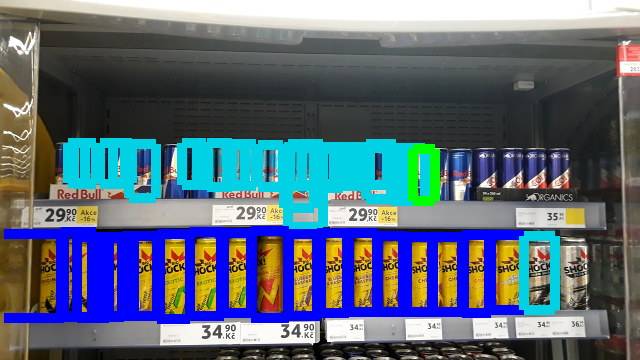

In [47]:
  ### color the shelves based on recognition
  tmp = bucket.blob(photos[-4]).download_as_string()
  img3 = Img.open(io.BytesIO(tmp))
  img3 = np.array(img3)
    
  pred_colored = colour_shelves_prediction(detections_wo, img3)
  pred_colored_red = colour_shelves(detections_wo, img)
  
  #pred_colored = colour_shelves_prediction(detections_wo, img_chopped_completed)
  pth = "https://storage.googleapis.com/" + bucket_name + "/detected_" + jsn['name']
  pth2 = "/detected_" + jsn['name'] + ".jpg"
  k = cv2.cvtColor(pred_colored, cv2.COLOR_RGB2BGR)
  cv2.imwrite("k.png", k)
  
  #Img.fromarray(pred_colored_red, 'RGB')  
  #Img.fromarray(img3, 'RGB') 
  Img.fromarray(pred_colored, 'RGB') 

In [22]:
#!gsutil cp 'gs://saleshousephotos/model/output_graph.pb' 'output_graph.pb' 

Copying gs://saleshousephotos/model/output_graph.pb...
\ [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     


In [44]:
#tmp = bucket.blob(photos[3]).download_as_string()
#img = Img.open(io.BytesIO(tmp))
#img = np.array(img)
#Img.fromarray(img, 'RGB')


detected_photo = cv2.cvtColor(pred_colored, cv2.COLOR_RGB2BGR)
cv2.imwrite("detected_photo.jpg", detected_photo)
bucket_name = 'saleshouse-test-output'
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob('detected/' + jsn['name'])
blob.upload_from_filename('detected_photo.jpg', content_type = 'image/jpg')
blob.make_public()
pth = "https://storage.googleapis.com/" + bucket_name + "/detected/" + jsn['name']
pth_raw = "https://storage.googleapis.com/" + jsn["bucket"] + jsn['name']

In [43]:
pth

'https://storage.googleapis.com/saleshouse-test-output/detected/photos/15428090045761973780038.jpg'

In [79]:
  ### calculate shelf ratio (percentage of shelf covered)

  sz = img_chopped_completed.shape[1]
  shelves_no = max(shlvs)
  df = list()

  for clss in class_names:
    for k in range(shelves_no+1):
      cntr = 0
      shelf_tuple = list()
      for idx, l in enumerate(detections_wo):
        if l['shelf'] == k:
          shelf_tuple.append(class_tuples[clss][idx])
          #if l['class'] == clss:
          cntr = cntr + 1

      sorted_by_lower_bound = sorted(shelf_tuple, key=lambda tup: tup[0])
      merged = []

      for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            if higher[0] <= lower[1]:
                upper_bound = max(lower[1], higher[1])
                merged[-1] = (lower[0], upper_bound)  # replace by merged interval
            else:
                merged.append(higher)

      zastoupeni = sum([i[1] - i[0] for i in merged])/sz
      plechovek = sum([i[1] - i[0] for i in merged])/np.median(sizes_x_arr)
      df.append({ 'shelf': k, 'class': clss, 'count_cans' : np.ceil(plechovek), 'count_boxes' : cntr,  'representation' : zastoupeni})
      #df.append({ 'shelf': k, 'class': clss, 'count_cans' : np.ceil(plechovek), 'representation' : zastoupeni})
      #print(clss, k, zastoupeni, np.ceil(plechovek))

  output_DF = pd.DataFrame(df)    

  output_DF['url_photo'] = pth_raw
  output_DF['url_photo_detected'] = pth
  output_DF['id_photo'] = int(jsn['generation'])
  output_DF['unique_id'] = output_DF["id_photo"].map(str) + output_DF["class"] + output_DF['shelf'].map(str)
  #output_DF['unique_id'] = output_DF["id_photo"].map(str)  + output_DF['shelf'].map(str)
  output_DF['shelf_sizes_est_x'] = int(true_sizes_x)
  output_DF['shelf_sizes_est_y'] = 15
  output_DF['representation'] = round(output_DF['representation'], 2)
  output_DF['retailer'] = 'Albert'
  output_DF['store'] = 'Vaclavske namesti 831/21 Praha 1 11000 (S2743CZ)'
  #output_DF

In [ ]:
#Img.fromarray(img_chopped_fin, 'RGB')

In [80]:
  ### write to bigquery

  client = bq.Client()
  dataset_id = 'db'
  table_id = 'recognition_output'

  def uploaddata(dataset_id, table_id, rows):
      table_ref = client.dataset(dataset_id).table(table_id)
      table = client.get_table(table_ref)
      errors = client.insert_rows(table, rows)

      assert errors == []

  output_DF['count_boxes'] = output_DF['count_boxes'].map(int)

  output_DF['date_added'] = pd.to_datetime(jsn['timeCreated']).astimezone(timezone('Europe/Berlin'))
  #output_DF['date_added'] =  datetime.utcnow() #pd.to_datetime('2018-11-21T14:03:42.757Z') #pd.to_timestamp(jsn['timeCreated'])
  output_DF['date_processed'] = datetime.datetime.now(datetime.timezone.cet).strftime("%Y-%m-%dT%H:%M:%S.%fZ") 

  #url_photo_detected
  sorted_DF = output_DF[['retailer','store','unique_id', 'id_photo', 'url_photo', 'url_photo_detected', 'shelf', 'class', 'representation', 'count_boxes', 'count_cans', 'shelf_sizes_est_x', 'shelf_sizes_est_y', 'date_added', 'date_processed']]
  tuples = [tuple(x) for x in sorted_DF.values]   
  uploaddata(dataset_id, table_id, tuples)

In [ ]:
#from datetime import datetime
  #datetime_object = datetime.strptime('2018-11-21T14:03:42.757Z', '%Y-%m-%dT%H:%M:%S.%fZ')

In [43]:
#sorted_DF
from pytz import timezone
#datetime.datetime.now(timezone('UTC')).astimezone(timezone('Europe/Berlin')).strftime("%Y-%m-%dT%H:%M:%S.%fZ")
datetime.datetime.now(timezone('Europe/Berlin')).strftime("%Y-%m-%dT%H:%M:%S.%fZ")

'2018-11-27T23:30:29.265695Z'

In [61]:
pd.to_datetime(jsn['timeCreated']).astimezone(timezone('Europe/Berlin')) #tzinfo = 'UTC'

TypeError: an integer is required (got type str)

In [45]:
pd.to_datetime(jsn['timeCreated']).tz_localize('UTC').tz_convert('Europe/Berlin').strftime("%Y-%m-%dT%H:%M:%S.%fZ")

'2018-11-21T15:03:42.757000Z'